[![Buy Me A Coffee](https://img.shields.io/badge/Buy%20Me%20A%20Coffee-support%20my%20work-FFDD00?style=flat&labelColor=101010&logo=buy-me-a-coffee&logoColor=white)](https://www.buymeacoffee.com/r0mymendez)

---

# TOON vs JSON for LLM Prompts: Can We Reduce Token Usage Without Losing Response Quality?
_A practical benchmark comparing TOON and JSON formats for LLM prompts_

|**Tags:** `llm`, `ai`, `optimization`, `python`|
-------------------------------------------------

![img-preview](img/preview.png)

---

# Introduction

Over the past months, I came across several articles claiming that **TOON** can significantly reduce token usage in **LLM** prompts compared to traditional **JSON**. Most of these examples, however, relied on small or artificial datasets.
That raised a few questions for me:
* Does TOON still provide benefits with **real-world API responses**?
* How much does it actually reduce tokens?
* And more importantly: **does changing the format affect how an LLM interprets the data or the quality of the response**?


Answering these questions isn’t trivial. Tokenization depends on the dataset, the structure of the data, and even the LLM itself. Still, I wanted to run a **practical benchmark** to see whether TOON is worth considering in production pipelines or if it’s just an optimization that looks good on paper.

_This article walks through the experiment, the results, and the conclusions._

----

# What Is TOON (and How Is It Different from JSON)?
**TOON (Terse Object-Oriented Notation** is a data serialization format designed specifically for LLM prompts. The goal is simple: reduce syntactic overhead while remaining readable for both humans and machines.

![img-json-vs-toon](img/toon_vs_json_file.png)

---

# The Experiment
## Datasets
In this experiment, I wanted to test TOON with **realistic, publicly available data**, rather than small, manually created datasets. Using real API responses allows us to see how token savings and LLM behavior hold up in practical scenarios.
I selected **two public APIs with very different characteristics:**
* **1. GitHub Events API:** Returns a **stream of recent public events on GitHub**, such as pushes, pull requests, issues, and comments.
    * **URL:** https://api.github.com/events
    * **Data structure:** Deeply nested, heterogeneous objects with multiple levels of dictionaries and arrays.
    * **Why this matters:** Represents the kind of **complex operational API** data you might send to an LLM in real projects.
* **2.  Wikipedia Page Views API:** Returns the top-viewed articles on English Wikipedia for a given day.
    * **URL:** https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/2024/01/01
    * **Data structure:** Flat, repetitive lists of articles, each with numeric metrics (title, views, category).
    * **Why this matters:** Ideal for testing TOON’s efficiency with **flat, repetitive data**, where token savings are expected to be highest.

> Using these two APIs allows us to evaluate TOON in both **complex nested** and **flat list scenarios**, giving a more comprehensive view of its performance in real-world LLM prompts.



PART 1: TOKEN REDUCTION BENCHMARK

Fetching GitHub events...
Fetching Wikipedia pages...
Fetching Wikipedia pages...

--- Token Reduction Summary ---
                reduction_pct                    
                         mean   std    min    max
dataset                                          
github_events            2.74  0.22   2.02   3.17
wikipedia_pages         42.61  6.66  13.64  46.70

--- Token Reduction Summary ---
                reduction_pct                    
                         mean   std    min    max
dataset                                          
github_events            2.74  0.22   2.02   3.17
wikipedia_pages         42.61  6.66  13.64  46.70


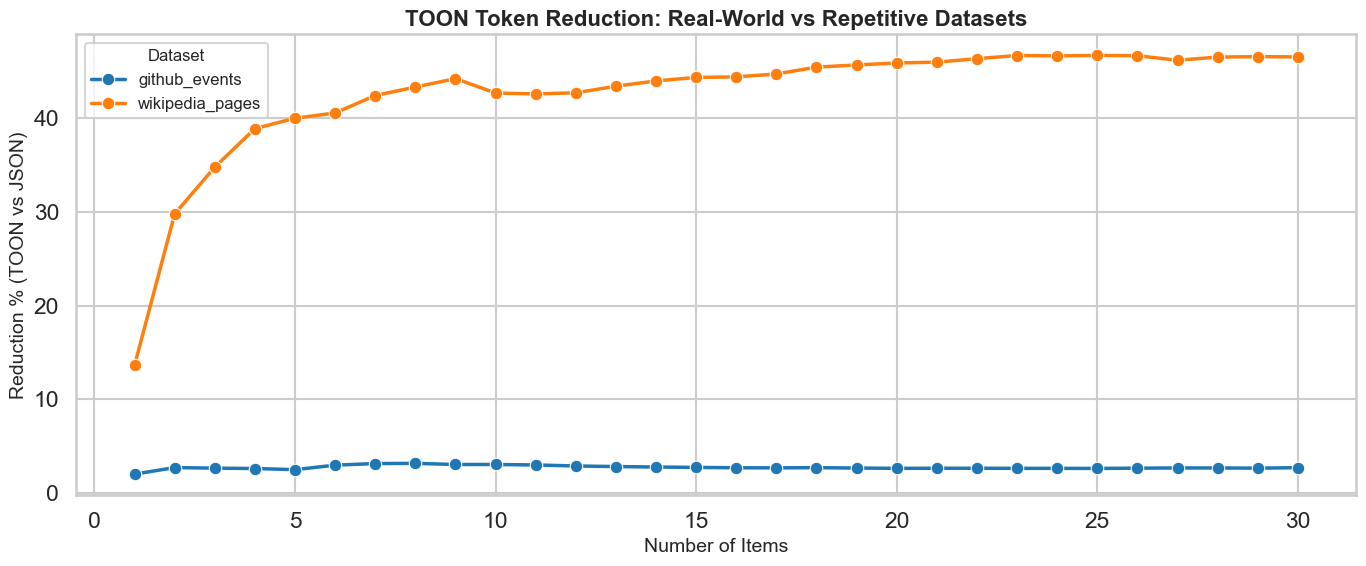

/Users/romina.mendez/Library/Python/3.9/lib/python/site-packages/boto3/compat.py:89: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)



✓ Results saved: output/token_reduction_results.csv
✓ Plot saved: output/token_reduction.png

PART 2: SEMANTIC QUALITY EVALUATION

Running 25 semantic evaluations...
Running 25 evaluations...


100%|██████████| 25/25 [03:32<00:00,  8.50s/it]




--- Semantic Quality Summary ---
       cosine_similarity  rouge1_f1  rougeL_f1     bleu
count            25.0000    25.0000    25.0000  25.0000
mean              0.9915     0.7471     0.6083  56.3349
std               0.0030     0.0338     0.0403   3.9216
min               0.9857     0.6443     0.5073  46.7057
25%               0.9894     0.7315     0.5854  54.6095
50%               0.9914     0.7451     0.6058  56.0676
75%               0.9935     0.7682     0.6263  59.3125
max               0.9972     0.8132     0.6943  63.1872

Generating visualizations...


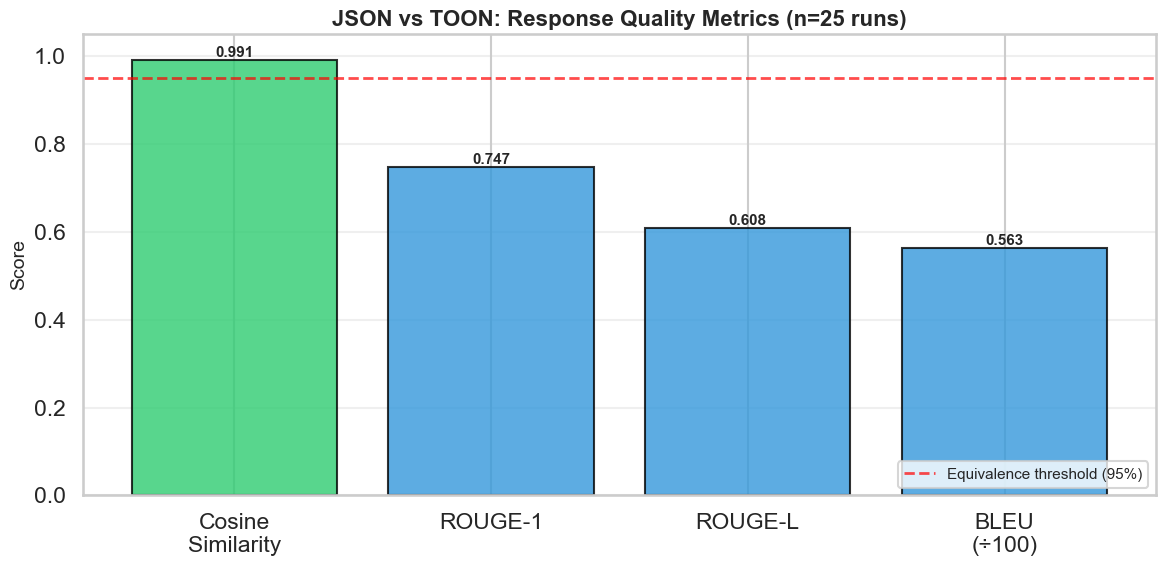

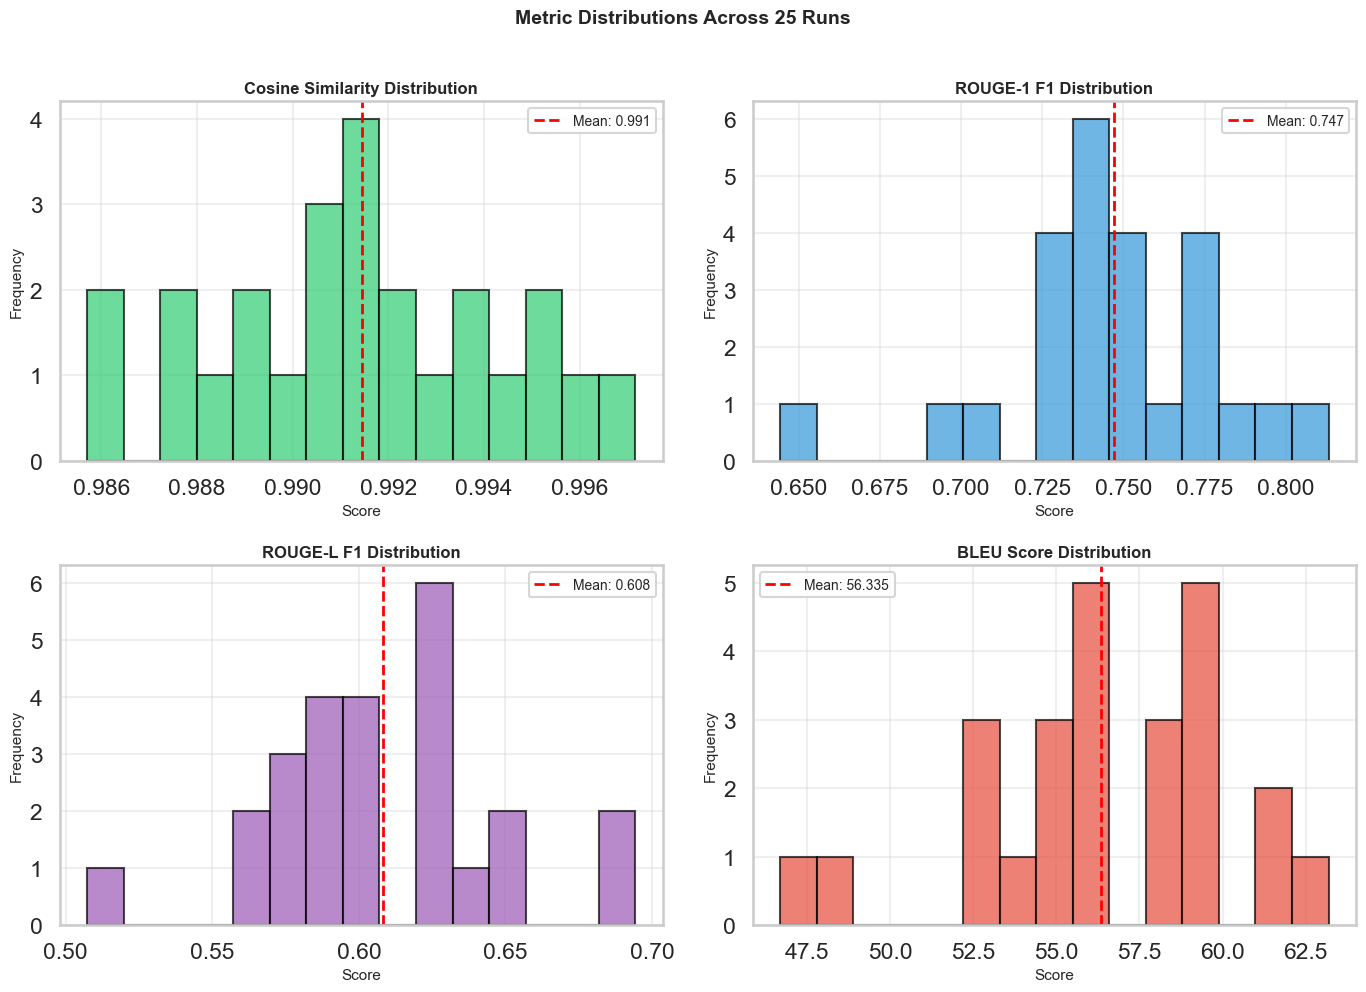


✓ Results saved: output/semantic_evaluation_results.csv
✓ Plot saved: output/semantic_metrics.png
✓ Plot saved: output/metric_distributions.png

BENCHMARK COMPLETE!

Generated files:
  • token_reduction_results.csv
  • token_reduction.png
  • semantic_evaluation_results.csv
  • semantic_metrics.png
  • metric_distributions.png


In [ ]:
"""
TOON vs JSON Benchmark for dev.to article
Complete analysis: Token reduction + Response quality metrics
"""

import tiktoken
import json
import requests
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from dataclasses import dataclass
from toon_format import encode as toon_encode
from rouge_score import rouge_scorer
from sacrebleu import sentence_bleu
from tqdm import tqdm


# ============================================================================
# CONFIGURATION
# ============================================================================

@dataclass
class BenchmarkConfig:
    """Configuration for benchmark experiments"""
    model: str = "gpt-4"
    region: str = "us-east-1"
    bedrock_model_prompt: str = "amazon.nova-lite-v1:0"
    bedrock_model_embedding: str = "amazon.titan-embed-text-v2:0"
    max_items: int = 30
    n_semantic_runs: int = 25  # Number of runs for semantic evaluation


# ============================================================================
# TOKEN COUNTER
# ============================================================================

class TokenCounter:
    """Count tokens using tiktoken"""
    
    def __init__(self, model: str = "gpt-4"):
        self.encoder = tiktoken.encoding_for_model(model)
    
    def count(self, text: str) -> int:
        """Count tokens in a text string"""
        return len(self.encoder.encode(text))


# ============================================================================
# DATA FETCHER
# ============================================================================

class DatasetFetcher:
    """Fetch datasets from different sources"""
    
    @staticmethod
    def fetch_github_events(limit: int = 30) -> List[Dict]:
        """Fetch recent GitHub events"""
        url = "https://api.github.com/events"
        response = requests.get(url)
        response.raise_for_status()
        return response.json()[:limit]
    
    @staticmethod
    def fetch_wikipedia_pages(limit: int = 30) -> List[Dict]:
        """Fetch popular Wikipedia pages"""
        headers = {
            "User-Agent": "TOON-Benchmark/1.0 (Research)"
        }
        url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/2024/01/01"
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        data = response.json()
        articles = data["items"][0]["articles"][:limit]
        return articles


# ============================================================================
# TOKEN BENCHMARK
# ============================================================================

class TokenBenchmark:
    """Benchmark token reduction: JSON vs TOON"""
    
    def __init__(self, config: BenchmarkConfig):
        self.config = config
        self.counter = TokenCounter(config.model)
    
    def incremental_benchmark(self, data_list: List[Dict], dataset_name: str) -> pd.DataFrame:
        """
        Perform incremental benchmark comparing JSON vs TOON
        
        Args:
            data_list: List of objects to analyze
            dataset_name: Name of dataset for identification
            
        Returns:
            DataFrame with benchmark results
        """
        results = []
        accum = []
        
        for idx, item in enumerate(data_list, start=1):
            accum.append(item)
            
            # Encode in both formats
            json_prompt = json.dumps(accum, ensure_ascii=False)
            toon_prompt = toon_encode(accum)
            
            # Count tokens
            json_tokens = self.counter.count(json_prompt)
            toon_tokens = self.counter.count(toon_prompt)
            
            # Calculate reduction
            saved = json_tokens - toon_tokens
            reduction_pct = (saved / json_tokens) * 100 if json_tokens else 0
            
            results.append({
                "num_items": idx,
                "JSON_tokens": json_tokens,
                "TOON_tokens": toon_tokens,
                "tokens_saved": saved,
                "reduction_pct": round(reduction_pct, 2),
                "dataset": dataset_name
            })
        
        return pd.DataFrame(results)


# ============================================================================
# AWS BEDROCK CLIENT
# ============================================================================

class AWSBedrockClient:
    """Client to interact with AWS Bedrock"""
    
    def __init__(self, region: str, model_prompt: str, model_embedding: str,
                 aws_access_key_id: str = None, aws_secret_access_key: str = None):
        self.region = region
        self.model_prompt = model_prompt
        self.model_embedding = model_embedding
        self.client = boto3.client(
            service_name='bedrock-runtime',
            region_name=region,
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key
        )
    
    def invoke_prompt(self, prompt: str, dataset: str = "", temperature: float = 0.0) -> str:
        """
        Invoke model with prompt
        
        Args:
            prompt: Base prompt
            dataset: Data to analyze (JSON or TOON encoded)
            temperature: 0 = deterministic, higher = more random
        """
        prompt_final = f"{prompt} {dataset}".strip()
        
        payload = {
            "messages": [
                {
                    "role": "user",
                    "content": [{"text": prompt_final}]
                }
            ],
            "inferenceConfig": {
                "max_new_tokens": 5000,
                "temperature": temperature,
                "top_p": 0.9
            }
        }
        
        try:
            response = self.client.invoke_model(
                modelId=self.model_prompt,
                body=json.dumps(payload)
            )
            response_body = json.loads(response['body'].read())
            return response_body['output']['message']['content'][0]['text']
        except Exception as e:
            raise Exception(f"Error invoking prompt model: {e}")
    
    def get_embeddings(self, text: str) -> List[float]:
        """Generate embeddings for a text"""
        payload = {"inputText": text}
        
        try:
            response = self.client.invoke_model(
                modelId=self.model_embedding,
                body=json.dumps(payload)
            )
            response_body = json.loads(response['body'].read())
            return response_body['embedding']
        except Exception as e:
            raise Exception(f"Error generating embeddings: {e}")


# ============================================================================
# SEMANTIC EVALUATOR
# ============================================================================

class SemanticEvaluator:
    """Evaluate semantic similarity between responses"""
    
    def __init__(self, bedrock_client: AWSBedrockClient):
        self.bedrock = bedrock_client
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], 
            use_stemmer=True
        )
    
    @staticmethod
    def cosine_similarity(vec1: List[float], vec2: List[float]) -> float:
        """Calculate cosine similarity between two vectors"""
        vec1 = np.array(vec1)
        vec2 = np.array(vec2)
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def evaluate_single_run(self, prompt: str, json_data: str, toon_data: str) -> Dict[str, float]:
        """
        Evaluate a single run with all metrics
        
        Returns:
            Dictionary with cosine, rouge, and bleu scores
        """
        # Get responses from both formats
        response_json = self.bedrock.invoke_prompt(prompt, json_data, temperature=0.0)
        response_toon = self.bedrock.invoke_prompt(prompt, toon_data, temperature=0.0)
        
        # 1. Cosine similarity (semantic)
        emb_json = self.bedrock.get_embeddings(response_json)
        emb_toon = self.bedrock.get_embeddings(response_toon)
        cosine_sim = self.cosine_similarity(emb_json, emb_toon)
        
        # 2. ROUGE scores (lexical overlap)
        rouge_scores = self.rouge_scorer.score(response_json, response_toon)
        
        # 3. BLEU score (lexical precision)
        bleu = sentence_bleu(response_toon, [response_json])
        
        return {
            'cosine_similarity': float(cosine_sim),
            'rouge1_f1': float(rouge_scores['rouge1'].fmeasure),
            'rouge2_f1': float(rouge_scores['rouge2'].fmeasure),
            'rougeL_f1': float(rouge_scores['rougeL'].fmeasure),
            'bleu': float(bleu.score)
        }
    
    def evaluate_multiple_runs(self, prompt: str, data: List[Dict], n_runs: int = 25) -> pd.DataFrame:
        """
        Run evaluation multiple times for robust statistics
        
        Args:
            prompt: Analysis prompt
            data: Data to analyze
            n_runs: Number of independent runs
            
        Returns:
            DataFrame with all runs and metrics
        """
        json_data = json.dumps(data, ensure_ascii=False)
        toon_data = toon_encode(data)
        
        results = []
        
        print(f"Running {n_runs} evaluations...")
        for run in tqdm(range(n_runs)):
            metrics = self.evaluate_single_run(prompt, json_data, toon_data)
            metrics['run'] = run + 1
            results.append(metrics)
        
        return pd.DataFrame(results)


# ============================================================================
# VISUALIZATION
# ============================================================================

class BenchmarkVisualizer:
    """Create visualizations for the article"""
    
    @staticmethod
    def plot_token_reduction(df: pd.DataFrame, save_path: str = None):
        """
        Plot token reduction over increasing items
        Original style maintained for dev.to article
        """
        sns.set_style("whitegrid")
        sns.set_context("talk")
        
        plt.figure(figsize=(14, 6))
        
        sns.lineplot(
            data=df,
            x="num_items",
            y="reduction_pct",
            hue="dataset",
            palette=["#1f77b4", "#ff7f0e"],
            marker="o",
            linewidth=2.5
        )
        
        plt.title("TOON Token Reduction: Real-World vs Repetitive Datasets", 
                 fontsize=16, weight='bold')
        plt.xlabel("Number of Items", fontsize=14)
        plt.ylabel("Reduction % (TOON vs JSON)", fontsize=14)
        plt.legend(title="Dataset", fontsize=12, title_fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    @staticmethod
    def plot_semantic_metrics(df: pd.DataFrame, save_path: str = None):
        """
        Plot semantic quality metrics
        Simple bar chart for dev.to article
        """
        sns.set_style("whitegrid")
        sns.set_context("talk")
        
        # Calculate means
        metrics_mean = {
            'Cosine\nSimilarity': df['cosine_similarity'].mean(),
            'ROUGE-1': df['rouge1_f1'].mean(),
            'ROUGE-L': df['rougeL_f1'].mean(),
            'BLEU\n(÷100)': df['bleu'].mean() / 100
        }
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Bar colors: green for semantic, blue for lexical
        colors = ['#2ecc71', '#3498db', '#3498db', '#3498db']
        
        bars = ax.bar(metrics_mean.keys(), metrics_mean.values(), 
                     color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=11, weight='bold')
        
        # Add equivalence threshold line
        ax.axhline(y=0.95, color='red', linestyle='--', linewidth=2, 
                  label='Equivalence threshold (95%)', alpha=0.7)
        
        ax.set_ylabel('Score', fontsize=14)
        ax.set_ylim([0, 1.05])
        ax.set_title(f'JSON vs TOON: Response Quality Metrics (n={len(df)} runs)', 
                    fontsize=16, weight='bold')
        ax.legend(fontsize=11, loc='lower right')
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    @staticmethod
    def plot_metric_distributions(df: pd.DataFrame, save_path: str = None):
        """
        Plot distribution of all metrics across runs
        Shows consistency/variability
        """
        sns.set_style("whitegrid")
        sns.set_context("talk")
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        metrics = [
            ('cosine_similarity', 'Cosine Similarity', '#2ecc71'),
            ('rouge1_f1', 'ROUGE-1 F1', '#3498db'),
            ('rougeL_f1', 'ROUGE-L F1', '#9b59b6'),
            ('bleu', 'BLEU Score', '#e74c3c')
        ]
        
        for idx, (metric, title, color) in enumerate(metrics):
            ax = axes[idx // 2, idx % 2]
            
            # Histogram
            ax.hist(df[metric], bins=15, alpha=0.7, color=color, 
                   edgecolor='black')
            
            # Mean line
            mean_val = df[metric].mean()
            ax.axvline(mean_val, color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_val:.3f}')
            
            ax.set_xlabel('Score', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{title} Distribution', fontsize=12, weight='bold')
            ax.legend(fontsize=10)
            ax.grid(alpha=0.3)
        
        plt.suptitle(f'Metric Distributions Across {len(df)} Runs', 
                    fontsize=14, weight='bold', y=1.00)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def run_complete_benchmark(config: BenchmarkConfig, 
                          aws_access_key: str, 
                          aws_secret_access_key: str):
    
    print("="*80)
    print("PART 1: TOKEN REDUCTION BENCHMARK")
    print("="*80)
    
    # Initialize components
    fetcher = DatasetFetcher()
    token_benchmark = TokenBenchmark(config)
    
    # Fetch datasets
    print("\nFetching GitHub events...")
    events = fetcher.fetch_github_events(config.max_items)
    df_events = token_benchmark.incremental_benchmark(events, "github_events")
    
    print("Fetching Wikipedia pages...")
    wikipedia = fetcher.fetch_wikipedia_pages(config.max_items)
    df_wikipedia = token_benchmark.incremental_benchmark(wikipedia, "wikipedia_pages")
    
    # Combine results
    df_token_reduction = pd.concat([df_events, df_wikipedia], ignore_index=True)
    
    # Show summary
    print("\n--- Token Reduction Summary ---")
    summary = df_token_reduction.groupby('dataset').agg({
        'reduction_pct': ['mean', 'std', 'min', 'max']
    }).round(2)
    print(summary)
    
    # Visualize
    visualizer = BenchmarkVisualizer()
    visualizer.plot_token_reduction(df_token_reduction, "output/token_reduction.png")
    
    # Save results
    df_token_reduction.to_csv("output/token_reduction_results.csv", index=False)
    print("\n✓ Results saved: output/token_reduction_results.csv")
    print("✓ Plot saved: output/token_reduction.png")
    
    # ========================================================================
    
    print("\n" + "="*80)
    print("PART 2: SEMANTIC QUALITY EVALUATION")
    print("="*80)
    
    # Initialize Bedrock client
    bedrock = AWSBedrockClient(
        region=config.region,
        model_prompt=config.bedrock_model_prompt,
        model_embedding=config.bedrock_model_embedding,
        aws_access_key_id=aws_access_key,
        aws_secret_access_key=aws_secret_access_key
    )
    
    # Initialize evaluator
    evaluator = SemanticEvaluator(bedrock)
    
    # Define analysis prompt
    ANALYSIS_PROMPT = """You have a list of Wikipedia articles with their number of views and ranking.
            Analyze the data and answer the following:
            1. What are the 3 most popular articles?
            2. What is the average number of views?
            3. Identify any notable trends (for example, articles with significantly fewer views).

            Here is the data:
            """
    
    # Run evaluation
    print(f"\nRunning {config.n_semantic_runs} semantic evaluations...")
    df_semantic = evaluator.evaluate_multiple_runs(
        ANALYSIS_PROMPT, 
        wikipedia, 
        config.n_semantic_runs
    )
    
    # Show summary
    print("\n--- Semantic Quality Summary ---")
    summary_stats = df_semantic[['cosine_similarity', 'rouge1_f1', 'rougeL_f1', 'bleu']].describe()
    print(summary_stats.round(4))
    
    # Visualizations
    print("\nGenerating visualizations...")
    visualizer.plot_semantic_metrics(df_semantic, "output/semantic_metrics.png")
    visualizer.plot_metric_distributions(df_semantic, "output/metric_distributions.png")
    
    # Save results
    df_semantic.to_csv("output/semantic_evaluation_results.csv", index=False)
    print("\n✓ Results saved: output/semantic_evaluation_results.csv")
    print("✓ Plot saved: output/semantic_metrics.png")
    print("✓ Plot saved: output/metric_distributions.png")
    
    # ========================================================================
    
    print("\n" + "="*80)
    print("BENCHMARK COMPLETE!")
    print("="*80)
    print("\nGenerated files:")
    print("  • token_reduction_results.csv")
    print("  • token_reduction.png")
    print("  • semantic_evaluation_results.csv")
    print("  • semantic_metrics.png")
    print("  • metric_distributions.png")
    
    return df_token_reduction, df_semantic


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    from dotenv import load_dotenv
    import os
    
    # Load credentials
    load_dotenv()
    
    # Configuration
    config = BenchmarkConfig(
        max_items=30,
        n_semantic_runs=25
    )
    
    # Run complete benchmark
    df_tokens, df_semantic = run_complete_benchmark(
        config=config,
        aws_access_key=os.getenv("AWS_ACCESS_KEY"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
    )

In [ ]:
# Test tqdm import
from tqdm import tqdm
import os

# Test if tqdm works
for i in tqdm(range(5)):
    pass
print("✓ tqdm working correctly")

# Test environment variables
from dotenv import load_dotenv
load_dotenv()

print(f"AWS_ACCESS_KEY loaded: {'Yes' if os.getenv('AWS_ACCESS_KEY') else 'No'}")
print(f"AWS_SECRET_ACCESS_KEY loaded: {'Yes' if os.getenv('AWS_SECRET_ACCESS_KEY') else 'No'}")